# Time-Series Forecasting using hourly energy consumption data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

color_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

file_path = './data/Energy Consumption/PJME_hourly.csv'

# Data Loading and Preparation

In [2]:
df = pd.read_csv(file_path)
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


We want to set the index to datetime since the we have hourly-based data

In [3]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


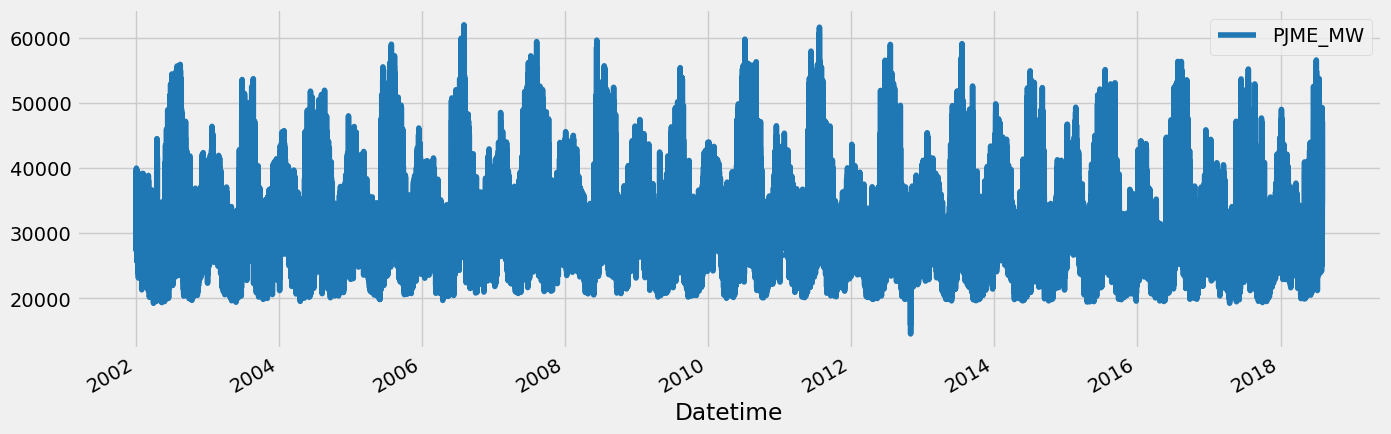

In [4]:
df.plot(style = '-', figsize = (15, 5), color = color_palette[0], )
plt.show()

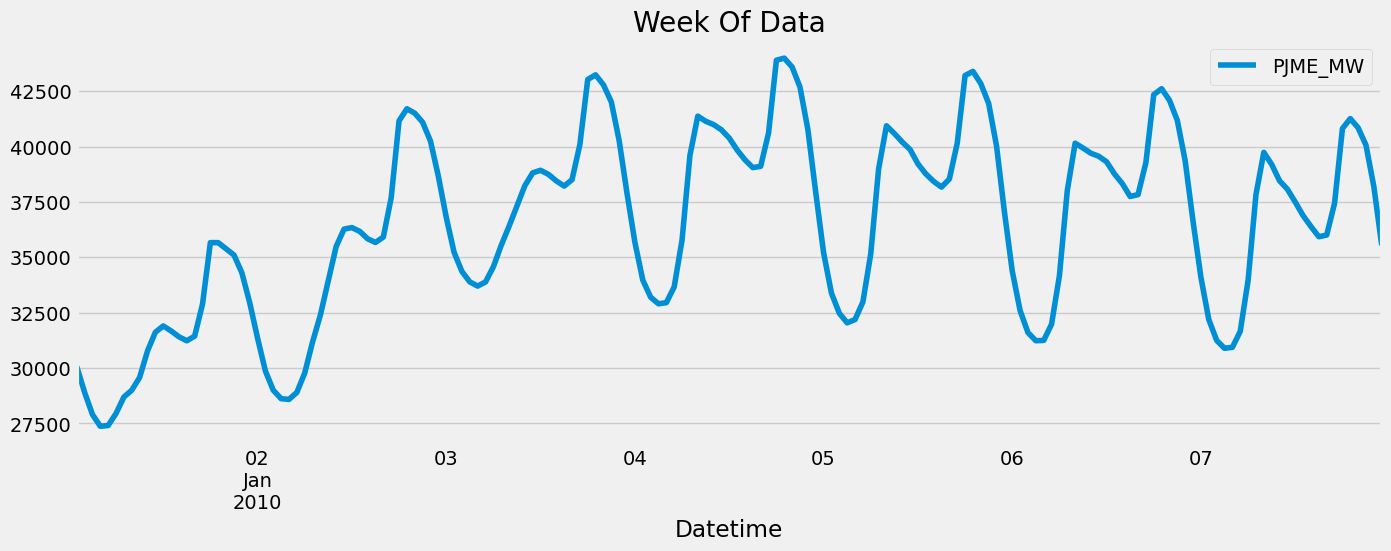

In [5]:
df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')] \
  .sort_index() \
  .plot(style='-', figsize=(15, 5), title='Week Of Data')
plt.show()

We want to add features relevant to the time-series nature of the data, such as:
- The hour of the day
- The day of the week
- The week of the year
- The day of the month
- The month of the year
- The Quarter of the year
- If it is a weekend day
- If it is a Monday
- If it is the start of the year
- If it is the end of the year

In [6]:
def create_features(df):
    df = df.copy()
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    df['is_Monday'] = (df.index.dayofweek == 0).astype(int)
    df['is_year_start'] = df.index.is_year_start.astype(int)
    df['is_year_end'] = df.index.is_year_end.astype(int)

    return df

df = create_features(df)

We can also look at the correlations of these features.

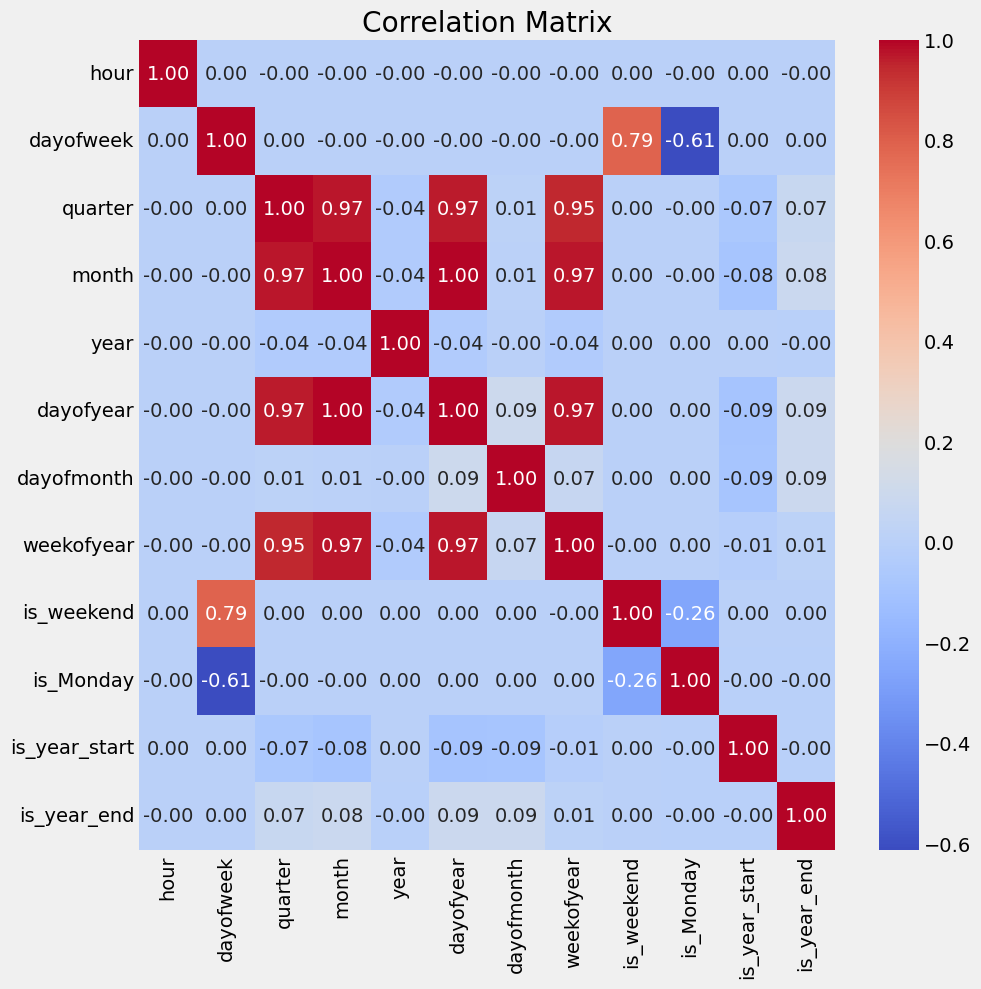

In [7]:
corr_matrix = df.drop(['PJME_MW'], axis = 1).corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

Of course some features are correlated with others, i.e., the weekend and Mondays with the day of the week, however these will potentially provide additional information to the model for better predictions.

Now we can split the data for training and testing. We will use the data until 2016 for training, and the remaining for testing.

In [8]:
train = df[df.index < '01-01-2016']
test = df[df.index >= '01-01-2016']

In [9]:
train.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_Monday,is_year_start,is_year_end
Datetime,,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,0,0,0,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,0,0,0,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,0,0,0,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,0,0,0,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,0,0,0,1


In [10]:
train.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_Monday,is_year_start,is_year_end
Datetime,,,,,,,,,,,,,
2015-01-01 20:00:00,34832.0,20,3,1,1,2015,1,1,1,0,0,1,0
2015-01-01 21:00:00,34302.0,21,3,1,1,2015,1,1,1,0,0,1,0
2015-01-01 22:00:00,33227.0,22,3,1,1,2015,1,1,1,0,0,1,0
2015-01-01 23:00:00,31460.0,23,3,1,1,2015,1,1,1,0,0,1,0
2015-01-02 00:00:00,29603.0,0,4,1,1,2015,2,2,1,0,0,0,0


In [11]:
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_Monday,is_year_start,is_year_end
Datetime,,,,,,,,,,,,,
2016-01-01 00:00:00,26686.0,0,4,1,1,2016,1,1,53,0,0,1,0
2016-12-31 01:00:00,29627.0,1,5,4,12,2016,366,31,52,1,0,0,1
2016-12-31 02:00:00,28744.0,2,5,4,12,2016,366,31,52,1,0,0,1
2016-12-31 03:00:00,28274.0,3,5,4,12,2016,366,31,52,1,0,0,1
2016-12-31 04:00:00,28162.0,4,5,4,12,2016,366,31,52,1,0,0,1


In [12]:
test.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_Monday,is_year_start,is_year_end
Datetime,,,,,,,,,,,,,
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,0,1,1,0
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,0,1,1,0
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,0,1,1,0
2018-01-01 23:00:00,40164.0,23,0,1,1,2018,1,1,1,0,1,1,0
2018-01-02 00:00:00,38608.0,0,1,1,1,2018,2,2,1,0,0,0,0


In [13]:
FEATURES = df.drop(["PJME_MW"], axis = 1).columns
TARGET = 'PJME_MW'

In [14]:
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(train[FEATURES]), columns = FEATURES)
x_test = pd.DataFrame(scaler.transform(test[FEATURES]), columns = FEATURES)
y_train = train[TARGET]
y_test = test[TARGET]

In [15]:
x_train.describe()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_Monday,is_year_start,is_year_end
count,122686.000000,122686.000000,122686.000000,122686.000000,122686.000000,122686.000000,122686.000000,122686.000000,122686.000000,122686.000000,122686.000000,122686.000000
mean,0.500084,0.499806,0.502904,0.502128,0.499996,0.498930,0.490976,0.492282,0.285412,0.142804,0.002731,0.002739
std,0.300942,0.333238,0.372328,0.313503,0.310064,0.288838,0.293309,0.289630,0.451612,0.349874,0.052183,0.052261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.260870,0.166667,0.333333,0.272727,0.230769,0.249315,0.233333,0.250000,0.000000,0.000000,0.000000,0.000000
50%,0.521739,0.500000,0.666667,0.545455,0.461538,0.498630,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000
75%,0.782609,0.833333,1.000000,0.818182,0.769231,0.747945,0.733333,0.750000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model Design and Training

For this project we will use a PyTorch Deep Neural Network in order to predict the energy consumption.

In [34]:
class SimpleDNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=1):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.fc3 = nn.Linear(int(hidden_size/2), int(hidden_size/4))
        self.fc4 = nn.Linear(int(hidden_size/4), output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x) 

We want to train using thr M3 GPU.

The training will consist of 40 epochs, with a batch size of $7\times 24 = 168$ to split the data every 7 days.

In PyTorch, in contrast to TensorFlow, the training needs to be done manually.
Thus, we need to set the model in training mode first using `model.train()` and then zero out the existing gradients.
Then we evaluate the model using `model(x_batch)` and calculate the loss (in this case, the mean squared error) using `criterion(outputs, y_batch)`.
Here the `criterion` is the `torch.nn.MSELoss()`.
Subsequently, we perform the back propagation using `loss.backward()` and update the model parameters with `optimizer.step()`.
Lastly, we switch to evaluation mode to calculate the train and test loss for the epoch with `model.eval()`.

Epoch 1, Train Loss: 1033881152.0000, Test Loss: 1011188416.0000
Epoch 2, Train Loss: 1023333184.0000, Test Loss: 994450944.0000
Epoch 3, Train Loss: 988165120.0000, Test Loss: 937834368.0000
Epoch 4, Train Loss: 915876096.0000, Test Loss: 823216128.0000
Epoch 5, Train Loss: 802293056.0000, Test Loss: 650783296.0000
Epoch 6, Train Loss: 654936128.0000, Test Loss: 446075872.0000
Epoch 7, Train Loss: 493851296.0000, Test Loss: 257076000.0000
Epoch 8, Train Loss: 349496832.0000, Test Loss: 134935712.0000
Epoch 9, Train Loss: 250154544.0000, Test Loss: 92032088.0000
Epoch 10, Train Loss: 199122464.0000, Test Loss: 87850336.0000
Epoch 11, Train Loss: 175753392.0000, Test Loss: 88553488.0000
Epoch 12, Train Loss: 162922448.0000, Test Loss: 87915664.0000
Epoch 13, Train Loss: 153710160.0000, Test Loss: 86514992.0000
Epoch 14, Train Loss: 145861040.0000, Test Loss: 84876968.0000
Epoch 15, Train Loss: 138636976.0000, Test Loss: 83200080.0000
Epoch 16, Train Loss: 131778544.0000, Test Loss: 8155

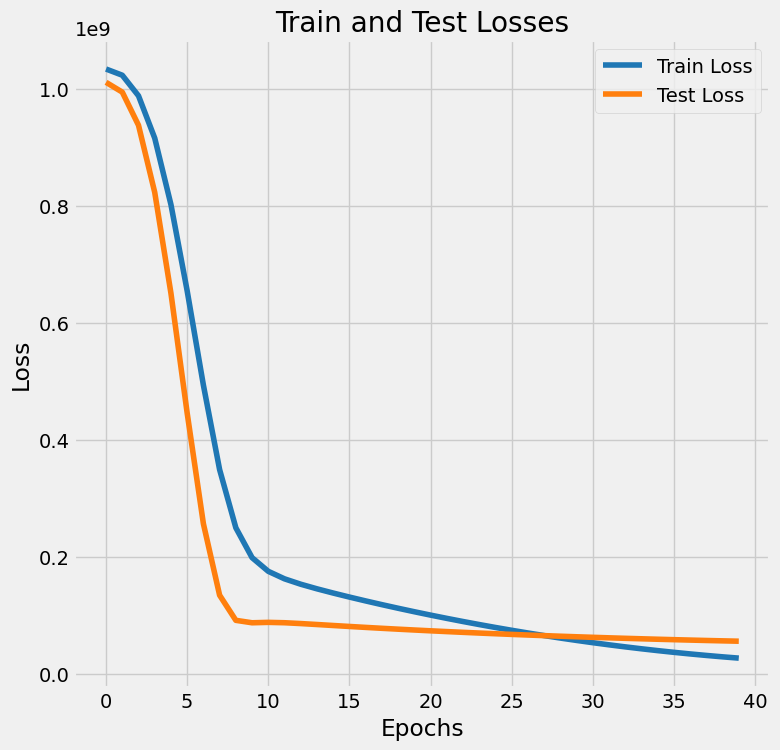

In [35]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

batch_size = 168
epochs = 40
model = SimpleDNN(input_size=len(FEATURES)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

losses = []
best_loss = float('inf')
patience = 5
counter = 0

for epoch in range(epochs):
    model.train()
    for i in range(0, len(x_train_tensor), batch_size):
        x_batch = x_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)

    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
    losses.append([loss.item(), test_loss.item()])

    # Early stopping logic
    if test_loss.item() < best_loss:
        best_loss = test_loss.item()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

losses = np.array(losses)

plt.figure(figsize = (8, 8))
plt.plot(losses[:, 0], label='Train Loss', color=color_palette[0])
plt.plot(losses[:, 1], label='Test Loss', color=color_palette[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()

We can now make predictions on the test data and compare with the expected results.

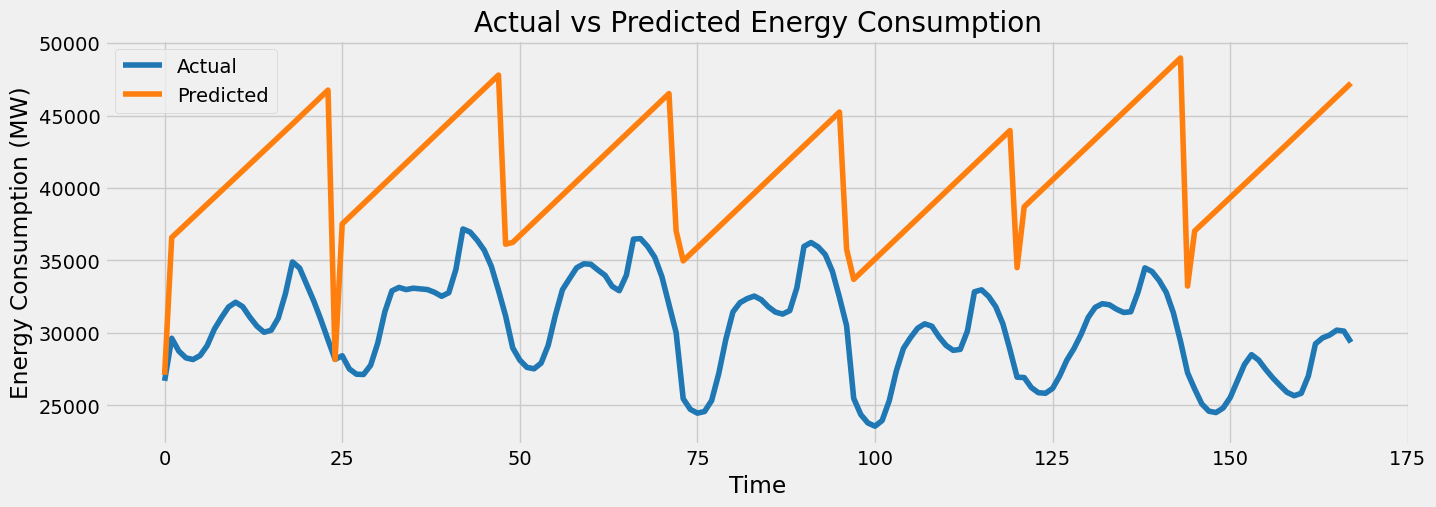

In [38]:
model.eval()
predictions = model(x_test_tensor)
plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:168], label='Actual', color=color_palette[0])
plt.plot(predictions.cpu().detach().numpy()[:168], label='Predicted', color=color_palette[1])
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

Index(['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'is_weekend', 'is_Monday', 'is_year_start',
       'is_year_end'],
      dtype='object')